Quantization

In [1]:
#libraries

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
import utils

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# For reproducibility
np.random.seed(42)
N_JOBS = 2


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#get data
all_M= pd.read_csv("/data/UKBB/kyra/capture24_magnitude_flat.csv")

all_M_norm= all_M-1

In [6]:
#random 10% sample


# Take a random sample of 20% of the data
sample_frac = 0.1
sample_idx = np.random.choice(all_M_norm.index, size=int(len(all_M_norm) * sample_frac), replace=False)

all_M_norm_sample= all_M_norm.iloc[sample_idx]

<h3> Cut points for quanitisation


- `Arbitrary`
- `Distribution Driven`

<h4> Naive cut points (baseline)

In [7]:
# Calculate the minimum and maximum of all_M_norm
min_val = np.min(all_M_norm_sample)
max_val = np.max(all_M_norm_sample)

# Divide the range into 20 equal parts
arbitrary_cuts = np.linspace(min_val, max_val, 21)  # 21 points create 20 equal intervals

print("Arbitrary cuts (range divided into 20 equal parts):")
print(arbitrary_cuts)

Arbitrary cuts (range divided into 20 equal parts):
[-0.99068361 -0.29250863  0.40566635  1.10384133  1.80201631  2.50019129
  3.19836627  3.89654125  4.59471623  5.29289122  5.9910662   6.68924118
  7.38741616  8.08559114  8.78376612  9.4819411  10.18011608 10.87829106
 11.57646604 12.27464102 12.972816  ]


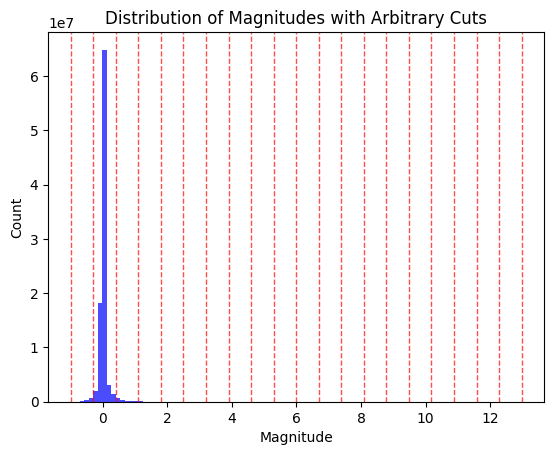

In [8]:

# Plot the histogram
plt.hist(all_M_norm_sample, bins=100, alpha=0.7, color='blue')
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes with Arbitrary Cuts")

# Add vertical lines for the arbitrary cuts
for cut in arbitrary_cuts:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

<h4>Data Distribution driven

1. Based on mass of distribution- more cut points inside 95% confidence interval, more spare outside of this interval

- `Evenly distributed across confidence interval`
- `Cuts particularly include mean, median, + - 1, 2 sds`


80% of the cut points within the 95% confidence interval

In [9]:
# Calculate the mean and standard deviation of all_M_norm
mean_all_M_norm = np.mean(all_M_norm_sample)
std_all_M_norm = np.std(all_M_norm_sample)

# Calculate the 95% confidence interval
ci_lower = mean_all_M_norm - 1.96 * std_all_M_norm
ci_upper = mean_all_M_norm + 1.96 * std_all_M_norm

# Divide the confidence interval into 16 equal parts
ci_cuts = np.linspace(ci_lower, ci_upper, 17)  # 17 points create 16 intervals

# Divide the remaining range into 4 equal parts (2 on each side of the CI)
lower_range = np.linspace(np.min(all_M_norm_sample), ci_lower, 3)[:-1]  # Exclude the upper bound to avoid overlap
upper_range = np.linspace(ci_upper, np.max(all_M_norm_sample), 3)[1:]  # Exclude the lower bound to avoid overlap

# Combine all cut points into a single array
ci_cut_points = np.concatenate([lower_range, ci_cuts, upper_range])

print("95% Confidence Interval:")
print(f"Lower: {ci_lower}, Upper: {ci_upper}")
print("\nAll 20 Cut Points:")
print(ci_cut_points)

/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


95% Confidence Interval:
Lower: Magnitude   -0.289926
dtype: float64, Upper: Magnitude    0.315402
dtype: float64

All 20 Cut Points:
[[-9.90683609e-01]
 [-6.40304918e-01]
 [-2.89926226e-01]
 [-2.52093219e-01]
 [-2.14260211e-01]
 [-1.76427203e-01]
 [-1.38594196e-01]
 [-1.00761188e-01]
 [-6.29281804e-02]
 [-2.50951727e-02]
 [ 1.27378349e-02]
 [ 5.05708426e-02]
 [ 8.84038502e-02]
 [ 1.26236858e-01]
 [ 1.64069866e-01]
 [ 2.01902873e-01]
 [ 2.39735881e-01]
 [ 2.77568888e-01]
 [ 3.15401896e-01]
 [ 6.64410895e+00]
 [ 1.29728160e+01]]


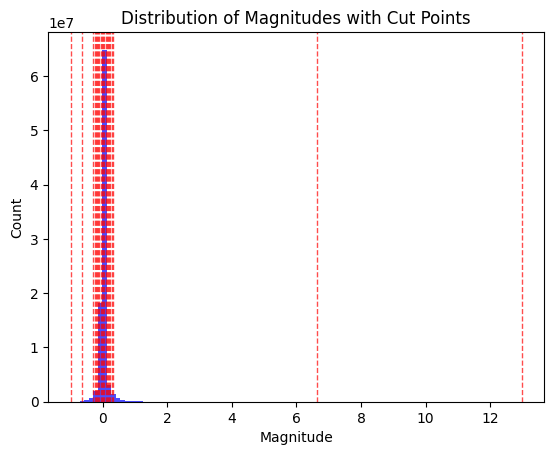

In [10]:
# Plot the histogram of all_M_norm
plt.hist(all_M_norm_sample, bins=100, alpha=0.7, color='blue')
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes with Cut Points")

# Add vertical lines for the cut points
for cut in ci_cut_points:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

# Show the plot
plt.show()

Mean, Median and Mode and 0.5 Standard deviation interval driven cut points

In [ ]:
# Calculate histogram and statistics for your data
all_M_norm_array = np.array(all_M_norm_sample).flatten()  # or use your data array

counts, bin_edges = np.histogram(all_M_norm_array, bins=100)
mean_val = np.mean(all_M_norm_array)
std_val = np.std(all_M_norm_array)
median_val = np.median(all_M_norm_array)

def find_bin(val, bin_edges):
    """Return the index of the bin that val falls into."""
    return np.searchsorted(bin_edges, val, side='right') - 1
# Calculate all std dev points, now including ±4 and ±5 std devs
sd_points = [
    mean_val - 5*std_val,
    mean_val - 4*std_val,
    mean_val - 3*std_val,
    mean_val - 2.5*std_val,
    mean_val - 2*std_val,
    mean_val - 1.5*std_val,
    mean_val - 1*std_val,
    mean_val - 0.5*std_val,
    mean_val,
    mean_val + 0.5*std_val,
    mean_val + 1*std_val,
    mean_val + 1.5*std_val,
    mean_val + 2*std_val,
    mean_val + 2.5*std_val,
    mean_val + 3*std_val,
    mean_val + 4*std_val,
    mean_val + 5*std_val
]

# Add median if it is different from mean
if not np.isclose(median_val, mean_val):
    sd_points.append(median_val)

# Find the mode bin (bin with the highest count)
mode_bin_idx = np.argmax(counts)
mode_bin_left = bin_edges[mode_bin_idx]
mode_bin_right = bin_edges[mode_bin_idx + 1]

# Add cut points for each side of the mode bin
sd_points.extend([mode_bin_left, mode_bin_right])

# Sort the cut points for clarity
sd_cuts = np.sort(np.array(sd_points))

# Print the bin for each cut point
for val in sd_cuts:
    bin_idx = find_bin(val, bin_edges)
    print(f"Value {val:.3f} is in bin {bin_idx} ({bin_edges[bin_idx]:.3f} to {bin_edges[bin_idx+1]:.3f})")

print("sd_cuts:", sd_cuts)

Value -0.761 is in bin 1 (-0.853 to -0.712)
Value -0.606 is in bin 2 (-0.712 to -0.571)
Value -0.451 is in bin 3 (-0.571 to -0.430)
Value -0.374 is in bin 4 (-0.430 to -0.289)
Value -0.297 is in bin 4 (-0.430 to -0.289)
Value -0.219 is in bin 5 (-0.289 to -0.148)
Value -0.142 is in bin 6 (-0.148 to -0.007)
Value -0.065 is in bin 6 (-0.148 to -0.007)
Value -0.007 is in bin 7 (-0.007 to 0.134)
Value 0.000 is in bin 7 (-0.007 to 0.134)
Value 0.013 is in bin 7 (-0.007 to 0.134)
Value 0.090 is in bin 7 (-0.007 to 0.134)
Value 0.134 is in bin 8 (0.134 to 0.275)
Value 0.167 is in bin 8 (0.134 to 0.275)
Value 0.245 is in bin 8 (0.134 to 0.275)
Value 0.322 is in bin 9 (0.275 to 0.416)
Value 0.400 is in bin 9 (0.275 to 0.416)
Value 0.477 is in bin 10 (0.416 to 0.557)
Value 0.632 is in bin 11 (0.557 to 0.698)
Value 0.786 is in bin 12 (0.698 to 0.839)
sd_cuts: [-7.60826324e-01 -6.06113061e-01 -4.51399798e-01 -3.74043167e-01
 -2.96686535e-01 -2.19329904e-01 -1.41973272e-01 -6.46166408e-02
 -6.99077

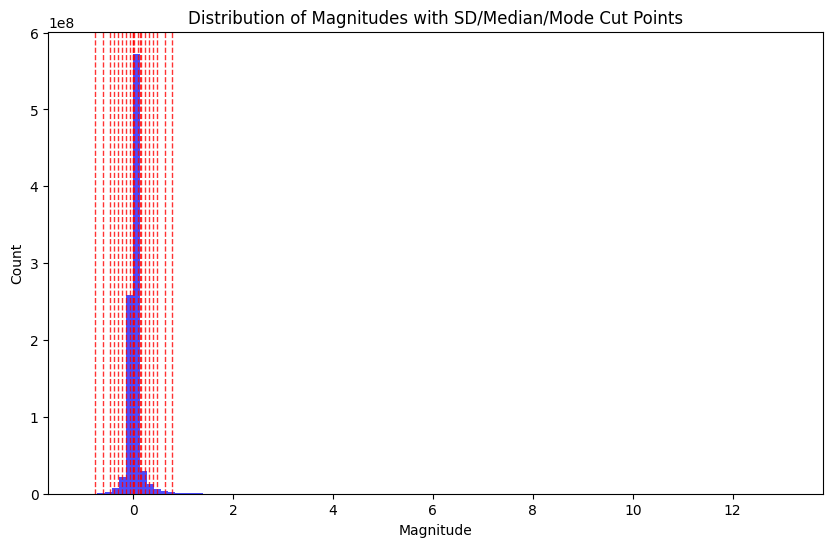

In [15]:
# Plot histogram of all_M_norm_array with vertical lines for sd_cuts

plt.figure(figsize=(10,6))
plt.hist(all_M_norm_array, bins=100, alpha=0.7, color='blue')
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes with SD/Median/Mode Cut Points")

# Add vertical lines for each cut point
for cut in sd_cuts:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.8)

plt.show()

PCA or TSNE to get cut points that capture the most variance.

In [ ]:
#?

Export 3 cut point version

In [18]:
# Create a DataFrame with the results
# Create a DataFrame with the results

# Ensure all cut arrays are 1D numpy arrays
arbitrary_cuts = np.array(arbitrary_cuts).flatten()
sd_cuts = np.array(sd_cuts).flatten()
ci_cut_points = np.array(ci_cut_points).flatten()

# Pad arrays to the same length for DataFrame export
max_len = max(len(arbitrary_cuts), len(sd_cuts), len(ci_cut_points))
def pad(arr, length):
    return np.pad(arr, (0, length - len(arr)), constant_values=np.nan)

cuts_df = pd.DataFrame({
    'arbitrary_cuts': pad(arbitrary_cuts, max_len),
    'sd_cuts': pad(sd_cuts, max_len),
    'ci_cuts': pad(ci_cut_points, max_len)
})



In [20]:
# Export to CSV
cuts_df.to_csv("cut_points.csv", index=False)